**Installing Packages.**

In [ ]:
!pip install opencv-python -q
!pip install numpy -q
!pip install matplotlib -q
!pip install easyocr -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 595.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 21.0 MB/s eta 0:00:00


**Importing Libraries.**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr
from google.colab.patches import cv2_imshow


**Initializing Constants.**

In [ ]:
#constants
IMAGE_PATH = '/content/rr.jpeg'
ADAPTIVE_THRESH_BLOCK_SIZE = 15
ADAPTIVE_THRESH_C = 5
GAUSSIAN_BLUR_KERNEL_SIZE = (5, 5)
CANNY_EDGE_DETECTION_THRESHOLD1 = 50
CANNY_EDGE_DETECTION_THRESHOLD2 = 150
MORPH_OPEN_KERNEL_SIZE = (2, 2)

**Loading Image of the sudoku Grid.**

In [ ]:
#load image
def load_image(image_path):
    """Loads an image from a file."""
    return cv2.imread(image_path)


**Preprocessing The Image.**

In [ ]:
    #grayscale
def convert_to_grayscale(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return image

    #adapative Thrashold
def apply_adaptive_thresholding(image):
  return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_C)

    #Guassion BLur
def apply_gaussian_blur(image):
  image = cv2.GaussianBlur(image, GAUSSIAN_BLUR_KERNEL_SIZE, 0)
  return image

def apply_morphological_operations(image):
  kernel = np.ones((3,3), np.uint8)
  mage = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
  return image


    #edge detection
def apply_canny_edge_detection(image):
  image = cv2.Canny(image, CANNY_EDGE_DETECTION_THRESHOLD1, CANNY_EDGE_DETECTION_THRESHOLD2)
  return image

    #Finding Contoures
def find_contours(image):
  contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  return contours


    #Finding Largest Contour
def find_largest_contour(contours):
  largest_contour = None
  max_area = 0
  for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            largest_contour = contour

  return largest_contour


def approximate_contour(contour):
  peri = cv2.arcLength(contour, True)
  return cv2.approxPolyDP(contour, 0.02 * peri, True)


    #Warpping the image with the preprocessed Contours
def warp_perspective(image, contour):
  if len(contour) < 4:
        return image
  pts1 = np.array([contour[0], contour[1], contour[2], contour[3]], dtype="float32")
  side_length = max(np.linalg.norm(pts1[0] - pts1[2]), np.linalg.norm(pts1[1] - pts1[3]))
  pts2 = np.array([[0, 0], [side_length - 1, 0], [side_length - 1, side_length - 1], [0, side_length - 1]], dtype="float32")
  M = cv2.getPerspectiveTransform(pts1, pts2)

  return cv2.warpPerspective(image, M, (int(side_length), int(side_length)))


**Extracting Numbers From the image that is provided by the user.**

In [ ]:
def extract_digits(image, reader):
    """Extracts digits from an image and saves each cell before extraction."""
    grid = [[0 for _ in range(9)] for _ in range(9)]
    cell_size = int(image.shape[0] / 9)

    for i in range(9):
        for j in range(9):


            # Extract cell
            cell = image[i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size]



            # Preprocess cell
            cell_gray = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)
            cell_thresh = cv2.adaptiveThreshold(cell_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_C)
            cell_thresh = cv2.bitwise_not(cell_thresh)
            cell_thresh = cell_thresh[10:255, 10:255]
            cell_thresh = apply_morphological_operations(cell_thresh)

            # Perform OCR on the cell
            result = reader.readtext(cell_thresh, detail=0, allowlist='123456789')
            if result and result[0].isdigit():
                grid[i][j] = int(result[0])
            else:
                grid[i][j] = 0

    return grid


**Detecting the Grid and then isolating each cell from the grid**

In [ ]:
def detect_sudoku_grid(image_path):
    """Detects and extracts a Sudoku grid from an image."""
    image = load_image(image_path)
    if image is None:
        print("Error: Image could not be loaded.")
        return None

    gray = convert_to_grayscale(image)
    thresh = apply_adaptive_thresholding(gray)
    thresh = cv2.bitwise_not(thresh)
    contours = find_contours(thresh)

    if len(contours) == 0:
        print("Error: No contours found.")
        return None

    largest_contour = find_largest_contour(contours)
    if largest_contour is None:
        print("Error: No largest contour found.")
        return None

    approx = approximate_contour(largest_contour)
    if len(approx) != 4:
        print("Error: Largest contour does not approximate to 4 points.")
        return None

    warped = warp_perspective(image, approx)
    if warped is None:
        print("Error: Warping perspective failed.")
        return None

    warped = cv2.flip(warped, 0)
    warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite("wrapped_image.jpg", warped)

    reader = easyocr.Reader(['en'], gpu=False)
    sudoku_grid = extract_digits(warped, reader)
    #plt.imshow(warped)

    if sudoku_grid is None:
        print("Error: Sudoku grid extraction failed.")
        return None

    return sudoku_grid

**Making the Grid and Solving it by using backTracking Algoritm.**

In [ ]:
def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")

        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")

            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end="")


def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)  # row, col

    return None


def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i

            if solve(bo):
                return True

            bo[row][col] = 0

    return False


def valid(bo, num, pos):
    # Check row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False

    return True


def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")

        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")

            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end="")


def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)  # row, col

    return None




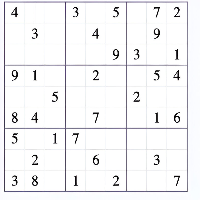

_________________________
4 9 6  | 3 1 5  | 8 7 2
1 3 8  | 2 4 7  | 6 9 5
2 5 7  | 6 8 9  | 3 4 1
- - - - - - - - - - - - - 
9 1 3  | 8 2 6  | 7 5 4
6 7 5  | 4 9 1  | 2 8 3
8 4 2  | 7 5 3  | 9 1 6
- - - - - - - - - - - - - 
5 6 1  | 9 3 8  | 4 2 7
7 2 9  | 5 6 4  | 1 3 8
3 8 4  | 1 7 2  | 5 6 9


In [ ]:
sudoku_grid = detect_sudoku_grid(IMAGE_PATH)
image1 = cv2.imread(IMAGE_PATH)
image1 = cv2.resize(image1, (200, 200))
cv2_imshow(image1)
solve(sudoku_grid)
print("_________________________")
print_board(sudoku_grid)